# MLGeometry guide

This introduction demonstrates how to use MLGeometry to: 
1. Generate a hypersurface.
2. Build a bihomogeneous neural network.
3. Use the model to compute numerical Calabi-Yau metrics with the embedding method.
4. Plot $\eta$ on a rational curve.

## Configure imports

Import tensorflow_probability to use the L-BFGS optimizer:

In [1]:
import sympy as sp
import tensorflow as tf
import tensorflow.python.keras.backend as K
import tensorflow_probability as tfp

In [2]:
import MLGeometry as mlg
from MLGeometry import bihomoNN as bnn

Import the libraries to plot the $\eta$ on the rational curve (see the last section):

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Set a random seed (optional)
Some random seed might be bad for numerical calulations. If there are any errors during the training, you may want to try a different seed.

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

## Define a hypersurface
First define a set of coordinates and a function as sympy symbols:

In [5]:
z0, z1, z2, z3, z4 = sp.symbols('z0, z1, z2, z3, z4')
Z = [z0,z1,z2,z3,z4]
f = z0**5 + z1**5 + z2**5 + z3**5 + z4**5 + 0.5*z0*z1*z2*z3*z4

Then define a hypersurface as a collection of points which solve the equation f = 0, using the `Hypersurface` class in the `mlg.hypersurface` module. The parameter n_pairs is the number of random pairs of points used to form the random lines in $\mathbf{CP}^{N+1}$. Then we take the intersections of those random lines and the hypersurface. By Bezout's theorem, each line intersects the hypersurface in precisely d points where d is the number of homogeneous coordinates. So the total number of points is d * n_pairs.

In [6]:
n_pairs = 10000
HS_train = mlg.hypersurface.Hypersurface(Z, f, n_pairs)
HS_test = mlg.hypersurface.Hypersurface(Z, f, n_pairs)

The Hypersurface class will take care of the patchwork automatically. Let's use the `list_patches` function to check the number of points on each patch:

In [7]:
HS_train.list_patches()

Number of Patches: 5
Points on patch 1 : 9933
Points on patch 2 : 10015
Points on patch 3 : 10249
Points on patch 4 : 10011
Points on patch 5 : 9792


You can also invoke this method on one of the patches to check the distribution on the subpatches:

In [8]:
HS_train.patches[0].list_patches()

Number of Patches: 4
Points on patch 1 : 2474
Points on patch 2 : 2468
Points on patch 3 : 2547
Points on patch 4 : 2444


The Hypersurface class contains some symbolic and numerical methods as well, which will be introduced elsewhere. 

## Training with Tensorflow
The following steps are similar to a regular Tensorflow training process. 
### Generate datasets
The `mlg.tf_dataset.generate_dataset` function converts a hypersurface to a Tensorflow Dataset, which has four componets: the points on the hypersurface, the volume form $\small \Omega \wedge \bar\Omega$, the mass reweighting the points distribution and the restriction which restricts the Kähler metric to a subpatch. The restriction contains an extra linear transformation so that points on different affine patches can all be processed in one call. It is also possible to generate a dataset only on one affine patch. 

In [9]:
train_set = mlg.tf_dataset.generate_dataset(HS_train)
test_set = mlg.tf_dataset.generate_dataset(HS_test)

2023-11-20 22:24:59.579042: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shuffle and batch the datasets:

In [10]:
train_set = train_set.shuffle(HS_train.n_points).batch(1000)
test_set = test_set.shuffle(HS_test.n_points).batch(1000)

Let's look at what is inside a dataset:

In [11]:
points, Omega_Omegabar, mass, restriction = next(iter(train_set))
print(points)

tf.Tensor(
[[-0.28939024-0.7013853j   0.36498785+0.31731284j  1.        -0.j
  -0.83973217-0.04013346j  0.69238067-0.44357434j]
 [-0.2632903 +0.00763338j  1.        +0.j         -0.3904083 -0.03917403j
  -0.07155564+0.36113203j  0.80278397+0.58611786j]
 [-0.9368906 +0.12442758j  0.21154833+0.6303546j  -0.3895686 +0.4952412j
  -0.22148535-0.86754274j  1.        -0.j        ]
 ...
 [-0.3757828 -0.8230363j  -0.176058  +0.23105958j -0.36762843+0.82377625j
  -0.28792354-0.0678029j   1.        -0.j        ]
 [ 0.38600475+0.27455673j  0.80249757+0.5882626j   1.        +0.j
  -0.0039644 +0.08065715j -0.46647677+0.11512545j]
 [ 0.8101118 -0.5754197j   1.        +0.j         -0.13839988-0.06433091j
  -0.17594224+0.5278059j  -0.47444513+0.20035468j]], shape=(1000, 5), dtype=complex64)


### Build a bihomogeneous neural network

The `mlg.bihomoNN` module provides the necessary layers (e.g. `Bihomogeneous` and `Dense` ) to construct the Kähler potential with a bihomogeneous neural network. Here is an example of a two-hidden-layer network (k = 4) with 70 and 100 hidden units:

In [12]:
class Kahler_potential(tf.keras.Model):
    def __init__(self):
        super(Kahler_potential, self).__init__()
        # The first layer transforms the complex points to the bihomogeneous form.
        # The number of the outputs is d^2, where d is the number of coordinates.
        self.bihomogeneous = bnn.Bihomogeneous(d=5)
        self.layer1 = bnn.SquareDense(5**2, 70, activation=tf.square)
        self.layer2 = bnn.SquareDense(70, 100, activation=tf.square)
        self.layer3 = bnn.SquareDense(100, 1)
    
    def call(self, inputs):
        x = self.bihomogeneous(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = tf.math.log(x)
        return x

In [13]:
model = Kahler_potential()

Define the Kähler metric $g_{i \bar j} = \partial_i\bar\partial_{\bar j} K$ and the volume form $d\mu_g = \det g_{i \bar j}$:

In [40]:
@tf.function
def volume_form(points, Omega_Omegabar, mass, restriction):
    
    kahler_metric = mlg.complex_math.complex_hessian(tf.math.real(model(points)), points)
    volume_form = tf.matmul(restriction, tf.matmul(kahler_metric, restriction, adjoint_b=True))
    volume_form = tf.math.real(tf.linalg.det(volume_form))
    
    # Calculate the normalization constant to make the overall integration as 1
    # It is a batchwise calculation but we expect it to converge to a constant eventually
    weights = mass / tf.reduce_sum(mass)
    factor = tf.reduce_sum(weights * volume_form / Omega_Omegabar)
    
    return volume_form / factor

### Train the model with Adam and L-BFGS
#### Adam
Setup the keras optmizer as `Adam` and the loss function as one of weighted loss in the `mlg.loss` module. Some available functions are `weighted_MAPE`, `weighted_MSE`, `max_error` and `MAPE_plus_max_error`. They are weighted with the mass formula since the points on the hypersurface are distributed according to the Fubini-Study measure while the measure used in the integration is determined by the volume form $\small \Omega \wedge \bar\Omega$.

In [15]:
optimizer = tf.keras.optimizers.Adam()
loss_func = mlg.loss.weighted_MAPE

Loop over the batches and train the network:

In [16]:
max_epochs = 500
epoch = 0
while epoch < max_epochs:
    epoch = epoch + 1
    for step, (points, Omega_Omegabar, mass, restriction) in enumerate(train_set):
        with tf.GradientTape() as tape:
            det_omega = volume_form(points, Omega_Omegabar, mass, restriction)
            loss = loss_func(Omega_Omegabar, det_omega, mass)
            grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    if epoch % 50 == 0:
        print("epoch %d: loss = %.5f" % (epoch, loss))

epoch 50: loss = 0.05577
epoch 100: loss = 0.05510
epoch 150: loss = 0.05734
epoch 200: loss = 0.02572
epoch 250: loss = 0.01227
epoch 300: loss = 0.01233
epoch 350: loss = 0.01112
epoch 400: loss = 0.01138
epoch 450: loss = 0.01123
epoch 500: loss = 0.01126


Let's check the loss of the test dataset. First define a function to calculate the total loss over the whole dataset:

In [17]:
def cal_total_loss(dataset, loss_function):
    total_loss = tf.constant(0, dtype=tf.float32)
    total_mass = tf.constant(0, dtype=tf.float32)
    
    for step, (points, Omega_Omegabar, mass, restriction) in enumerate(dataset):
        det_omega = volume_form(points, Omega_Omegabar, mass, restriction)
        mass_sum = tf.reduce_sum(mass)
        total_loss += loss_function(Omega_Omegabar, det_omega, mass) * mass_sum
        total_mass += mass_sum
    total_loss = total_loss / total_mass

    return total_loss.numpy()

Check the results of MAPE and MSE:

In [18]:
sigma_test = cal_total_loss(test_set, mlg.loss.weighted_MAPE)
E_test = cal_total_loss(test_set, mlg.loss.weighted_MSE)
print("sigma_test = %.5f" % sigma_test)
print("E_test = %.5f" % E_test)

sigma_test = 0.01152
E_test = 0.00024


You can also check the error of the Monte Carlo integration, estimated by: 

$$\delta \sigma = \frac{1}{\sqrt{N_p}} {\left( \int_X (|\eta - 1_X| - \sigma)^2 d\mu_{\Omega}\right)}^{1/2},$$

where $N_p$ is the number of points on the hypersurface and $\sigma$ is the `weighted_MAPE` loss, and 

$$\eta = \frac{\det \omega}{\small \Omega \wedge \bar \Omega}$$

In [19]:
def delta_sigma_square_test(y_true, y_pred, mass):
    weights = mass / K.sum(mass)
    return K.sum((K.abs(y_true - y_pred) / y_true - sigma_test)**2 * weights)

delta_sigma = cal_total_loss(test_set, delta_sigma_square_test)
print("delta_simga = %.5f" % delta_sigma)

delta_simga = 0.00011


#### Save and Load
The trained network can be saved by:

In [20]:
model.save('trained_model/70_100_1')

2023-11-20 22:55:44.358235: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: trained_model/70_100_1/assets


And loaded by the `load_model` method:

In [34]:
model = tf.keras.models.load_model('trained_model/70_100_1', compile=False)

#### L-BFGS
As elaborated in our paper, when the network getting more complicated, L-BFGS converges faster than Adam near the minima. It is recommanded to use it after pretraining with Adam. However, L-BFGS is not in the standard Tensorflow library so the training process is slightly different: (Only ~20 iterations are shown here. In a real case you may want to set the `max_epochs` to ~1000)

In [35]:
# The displayed max_epochs will be three to four times this value since iter + 1 everytime the function
# is invoked, which also happens during the evaluation of the function itself and its gradient
max_epochs = 5

# Setup the function to be optimized by L-BFGS

train_func = mlg.lbfgs.function_factory(model, loss_func, train_set)

# Setup the inital values and train
init_params = tf.dynamic_stitch(train_func.idx, model.trainable_variables)
results = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=train_func,
                                        initial_position=init_params,
                                        max_iterations=max_epochs)
# Update the model after the last loop
train_func.assign_new_model_parameters(results.position)

Iter: 1 loss: 0.01126137
Iter: 2 loss: 0.328403
Iter: 3 loss: 0.0821050107
Iter: 4 loss: 0.0218381956
Iter: 5 loss: 0.0112192212
Iter: 6 loss: 0.010805482
Iter: 7 loss: 0.0107237333
Iter: 8 loss: 0.0106950831
Iter: 9 loss: 0.0106076896
Iter: 10 loss: 0.0103853652
Iter: 11 loss: 0.0126166465
Iter: 12 loss: 0.010367115
Iter: 13 loss: 0.010289846
Iter: 14 loss: 0.0106641743
Iter: 15 loss: 0.0102756936
Iter: 16 loss: 0.010216374
Iter: 17 loss: 0.0105393333
Iter: 18 loss: 0.0102058034


Note that the definition of the volume form is already in the `mlg.lbfgs` module. Also note that the standard L-BFGS does not support multi-batch training. You can still batch the dataset in case the GPU is out of memory, but the parameters are only updated after a whole epoch. 

You can also check the test dataset:

In [23]:
sigma_test = cal_total_loss(test_set, mlg.loss.weighted_MAPE)
E_test = cal_total_loss(test_set, mlg.loss.weighted_MSE)
print("sigma_test = %.5f" % sigma_test)
print("E_test = %.5f" % E_test)

sigma_test = 0.01152
E_test = 0.00024


#### Print out the metrics
After all of the trainings are done, the final results for the metrics can be printed out explicitly, using the previously generated data points and restriction matrices:

In [31]:
@tf.function
def get_cy_metric(points, restriction):
    
    cy_metric = mlg.complex_math.complex_hessian(tf.math.real(model(points)), points)
    cy_metric = tf.matmul(restriction, tf.matmul(cy_metric, restriction, adjoint_b=True))
    
    return cy_metric

In [36]:
cy_metric = get_cy_metric(points, restriction)
print(points[5].numpy())
print(cy_metric[5].numpy())

[ 1.00010002e+00+1.000000e-04j -9.99899983e-01+1.000000e-04j
  1.01631376e-04-4.029025e-02j  9.99999975e-05+1.000000e-04j
  9.83686259e-05+4.049025e-02j]
[[ 2.4076002e+00-5.2405369e-10j -3.0694052e-03-1.5095331e-03j
   3.2606444e-03+2.4268660e-03j]
 [-3.0694064e-03+1.5095330e-03j  2.4089518e+00-4.6532023e-10j
  -1.9152319e-03-1.2335215e-03j]
 [ 3.2606435e-03-2.4268664e-03j -1.9152318e-03+1.2335217e-03j
   2.4050314e+00+2.3286617e-10j]]


### $\eta$ on the rational curve

Now let's retrict our model to a subspace and check the local behavior of $\eta$. With the quintic 3-fold f = 0, we can choose the embedding 

$$(z_0, -z_0, z_1, 0, -z_1),$$

and the local coordinate system defined by $t = z_1 / z_0$. Using shperical coordinates $(\theta, \phi)$, it can be embedded into $\mathbb{R}^3$ by:

$$z_0 = \sin \theta \cos \phi, \qquad z_1= \sin \theta \sin \phi + i \cos \phi$$

So first sample the points on the rational curve:

In [37]:
theta, phi = np.linspace(0.001,np.pi+0.001, 400), np.linspace(0.001, 2*np.pi+0.001, 400)
eps = 0.0001 + 0.0001j

R = []
points_list = []
for j in phi:
    for i in theta:
        t = complex(math.sin(i)*math.sin(j), math.cos(i)) / (math.sin(i)*math.cos(j))
        if np.absolute(t) <= 1:
            # The Bihomogeneous layer will remove the zero entries automatically.
            # So here we add a small number eps to avoid being removed
            points_list.append([1+eps, -1+eps, t+eps, 0+eps, -t+eps])
        else:
            # Use the symmetry:
            points_list.append([1+eps, -1+eps, 1/t+eps, 0+eps, -1/t+eps])

Use this set of points to generate the rational curve with norm_coordinate = z0 and max_grad_coordinate = z1:

In [38]:
rc = mlg.hypersurface.Hypersurface(Z, f, points=points_list, norm_coordinate=0, max_grad_coordinate=0)
rc_dataset = mlg.tf_dataset.generate_dataset(rc).batch(rc.n_points)

Calculate $\eta$:

In [41]:
points, Omega_Omegabar, mass, restriction = next(iter(rc_dataset))
det_omega = volume_form(points, Omega_Omegabar, mass, restriction)
eta = (det_omega / Omega_Omegabar).numpy()

Convert to Cartesian coordinates:

In [42]:
R = eta.reshape(400, 400)
THETA, PHI = np.meshgrid(theta, phi)
X = R * np.sin(THETA) * np.cos(PHI)
Y = R * np.sin(THETA) * np.sin(PHI)
ZZ = R * np.cos(THETA)

Plot the figure:

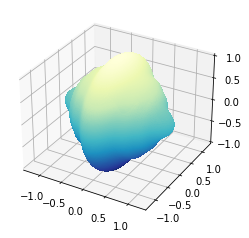

In [43]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.set_zlim3d(-1.0, 1.0)
plot = ax.plot_surface(
    X, Y, ZZ, rstride=1, cstride=1, cmap=plt.cm.YlGnBu_r,
    linewidth=0, antialiased=False)

$\eta$ is expected to approach the constant function 1 as k increases.